In [1]:
import flv_utils as flv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_reversal_fraction(velocity, window_size=200):
    """
    Compute fraction of time in reversal over half-overlapping rolling windows.
    
    Parameters:
    -----------
    velocity : array-like
        Velocity data array
    window_size : int
        Size of rolling window (default: 200). Will be adjusted to nearest even number.
        
    Returns:
    --------
    reversal_fractions : numpy array
        Array of reversal fractions for each window position
    window_centers : numpy array
        Center positions of each window (integer indices)
    """
    
    # Convert to numpy array if needed
    velocity = np.array(velocity)
    
    # Ensure window size is even for integer centers
    if window_size % 2 != 0:
        window_size += 1
    
    # Create forward/reverse boolean array (True = forward, False = reverse)
    fwd_rev = velocity > 0
    
    # Set stride to half the window size for half-overlapping windows
    stride = window_size // 2
    
    # Calculate number of possible windows with the given stride
    n_windows = (len(velocity) - window_size) // stride + 1
    
    if n_windows <= 0:
        raise ValueError(f"Window size ({window_size}) is larger than data length ({len(velocity)})")
    
    # Initialize arrays for results
    reversal_fractions = np.zeros(n_windows)
    window_centers = np.zeros(n_windows, dtype=int)
    
    # Compute rolling reversal fraction with half-overlapping windows
    for i in range(n_windows):
        # Calculate start index with stride
        start_idx = i * stride
        end_idx = start_idx + window_size
        
        # Extract window
        window = fwd_rev[start_idx:end_idx]
        
        # Calculate fraction of time in reversal (velocity <= 0)
        reversal_fraction = np.sum(~window) / window_size  # ~window gives reverse periods
        reversal_fractions[i] = reversal_fraction
        
        # Calculate window center position (now guaranteed to be integer)
        window_centers[i] = start_idx + window_size // 2 - 1
    
    return reversal_fractions, window_centers

def compute_binned_velocities(velocity, window_size=200):
    """
    Compute mean absolute velocity over half-overlapping rolling windows.
    
    Parameters:
    -----------
    velocity : array-like
        Velocity data array
    window_size : int
        Size of rolling window (default: 200). Will be adjusted to nearest even number.
        
    Returns:
    --------
    binned_velocities : numpy array
        Array of mean absolute velocities for each window position
    window_centers : numpy array
        Center positions of each window (integer indices)
    """
    
    # Convert to numpy array if needed
    velocity = np.array(velocity)
    
    # Ensure window size is even for integer centers
    if window_size % 2 != 0:
        window_size += 1
    
    # Calculate absolute velocities
    abs_velocity = np.abs(velocity)
    
    # Set stride to half the window size for half-overlapping windows
    stride = window_size // 2
    
    # Calculate number of possible windows with the given stride
    n_windows = (len(velocity) - window_size) // stride + 1
    
    if n_windows <= 0:
        raise ValueError(f"Window size ({window_size}) is larger than data length ({len(velocity)})")
    
    # Initialize arrays for results
    binned_velocities = np.zeros(n_windows)
    window_centers = np.zeros(n_windows, dtype=int)
    
    # Compute rolling mean absolute velocity with half-overlapping windows
    for i in range(n_windows):
        # Calculate start index with stride
        start_idx = i * stride
        end_idx = start_idx + window_size
        
        # Extract window
        window = abs_velocity[start_idx:end_idx]
        
        # Calculate mean absolute velocity
        binned_velocities[i] = np.mean(window)
        
        # Calculate window center position (now guaranteed to be integer)
        window_centers[i] = start_idx + window_size // 2 - 1
    
    return binned_velocities, window_centers


def compute_binned_pumping_rates(pumping_rate, window_size=200):
    """
    Compute mean pumping rate over half-overlapping rolling windows.
    
    Parameters:
    -----------
    pumping_rate : array-like
        Pumping rate data array
    window_size : int
        Size of rolling window (default: 200). Will be adjusted to nearest even number.
        
    Returns:
    --------
    binned_pumping_rates : numpy array
        Array of mean pumping rates for each window position
    window_centers : numpy array
        Center positions of each window (integer indices)
    """
    
    # Convert to numpy array if needed
    pumping_rate = np.array(pumping_rate)
    
    # Ensure window size is even for integer centers
    if window_size % 2 != 0:
        window_size += 1
    
    # Set stride to half the window size for half-overlapping windows
    stride = window_size // 2
    
    # Calculate number of possible windows with the given stride
    n_windows = (len(pumping_rate) - window_size) // stride + 1
    
    if n_windows <= 0:
        raise ValueError(f"Window size ({window_size}) is larger than data length ({len(pumping_rate)})")
    
    # Initialize arrays for results
    binned_pumping_rates = np.zeros(n_windows)
    window_centers = np.zeros(n_windows, dtype=int)
    
    # Compute rolling mean pumping rate with half-overlapping windows
    for i in range(n_windows):
        # Calculate start index with stride
        start_idx = i * stride
        end_idx = start_idx + window_size
        
        # Extract window
        window = pumping_rate[start_idx:end_idx]
        
        # Calculate mean pumping rate
        binned_pumping_rates[i] = np.mean(window)
        
        # Calculate window center position (now guaranteed to be integer)
        window_centers[i] = start_idx + window_size // 2 - 1
    
    return binned_pumping_rates, window_centers

In [3]:
def compute_below_zero_ratio(array):
    """
    Compute the ratio of below-zero values to total defined values for each row.
    
    Parameters:
    array: numpy array of shape (n_rows, n_cols) with potential NaN values
    
    Returns:
    numpy array of shape (n_rows,) containing ratios for each row
    """

    n_rows, n_cols = array.shape
    # Count defined (non-NaN) values per row
    defined_counts = np.sum(~np.isnan(array), axis=1)
    
    # Count below-zero values per row (NaN values are ignored by default in comparisons)
    below_zero_counts = np.sum(array < 0, axis=1)
    
    # Compute ratio, handling division by zero
    ratios = np.divide(below_zero_counts, defined_counts, 
                      out=np.zeros(n_rows), where=defined_counts != 0)
    
    return ratios


def flag_onset_transitions(binary_array):
    """
    Vectorized version for better performance.
    """
    n_animals, n_timepoints = binary_array.shape
    
    # Initialize flag array with zeros
    flag_array = np.zeros_like(binary_array)
    
    # Find animals that end with 0 in the last timepoint OR end with NaN
    # (animals ending with 1 should be excluded)
    last_values = binary_array[:, -1]
    animals_ending_zero = (last_values == 0) | np.isnan(last_values)
    
    # Handle first timepoint (onset from implicit 0 state)
    first_is_one = (binary_array[:, 0] == 1) & animals_ending_zero
    flag_array[first_is_one, 0] = 1
    
    if n_timepoints > 1:
        # Create shifted arrays to compare adjacent timepoints
        current = binary_array[:, 1:]  # timepoints 1 to end
        previous = binary_array[:, :-1]  # timepoints 0 to end-1
        
        # Find 0->1 transitions: previous==0 AND current==1
        transitions = (previous == 0) & (current == 1)
        
        # Only keep transitions for animals that end with 0
        transitions = transitions & animals_ending_zero[:, np.newaxis]
        
        # Place transition flags in the correct positions (at timepoint where 1 occurs)
        flag_array[:, 1:][transitions] = 1
    
    # Keep NaN values as NaN in the flag array
    flag_array[np.isnan(binary_array)] = np.nan
    
    return flag_array

In [4]:
def plot_heatmap_per_animal(data_dict, group_order=None, title='', clabel='', vmin=None, vmax=None, sort_method=None, colormap='coolwarm', figsize=(12, 10), show_colorbar=True):

    # Stack all data vertically with sorting and keep track of group boundaries
    all_data = []
    group_labels = []
    group_boundaries = [0]  # Start of first group

    if group_order is None:
        group_order = data_dict.keys()
    
    for key in group_order:
        group_data = data_dict[key]
        
        # Apply sorting within each group
        if sort_method is None:
            sorted_data = group_data
        elif sort_method == 'mean':
            # Sort by mean value across time (ignoring NaNs)
            sort_idx = np.argsort(np.nanmean(group_data, axis=1))
            sorted_data = group_data[sort_idx]
        elif sort_method == 'max':
            # Sort by maximum value across time
            sort_idx = np.argsort(np.nanmax(group_data, axis=1))
            sorted_data = group_data[sort_idx]
        elif sort_method == 'peak_time':
            # Sort by time of peak value
            peak_times = np.nanargmax(group_data, axis=1)
            sort_idx = np.argsort(peak_times)
            sorted_data = group_data[sort_idx]
        elif sort_method == 'hierarchical':
            # Hierarchical clustering for more complex patterns
            try:
                from scipy.cluster.hierarchy import linkage, leaves_list
                from scipy.spatial.distance import pdist
                
                # Remove rows that are all NaN
                valid_rows = ~np.all(np.isnan(group_data), axis=1)
                if np.sum(valid_rows) > 1:
                    valid_data = group_data[valid_rows]
                    row_means = np.nanmean(valid_data, axis=dict_color, keepdims=True)
                    filled_data = np.where(np.isnan(valid_data), row_means, valid_data)
                    
                    # Perform hierarchical clustering
                    distances = pdist(filled_data, metric='euclidean')
                    linkage_matrix = linkage(distances, method='ward')
                    cluster_order = leaves_list(linkage_matrix)
                    
                    # Create full sort index
                    sort_idx = np.arange(len(group_data))
                    sort_idx[valid_rows] = np.where(valid_rows)[0][cluster_order]
                    sorted_data = group_data[sort_idx]
                else:
                    sorted_data = group_data
            except ImportError:
                print("Warning: scipy not available, using unsorted data")
                sorted_data = group_data
        else:
            sorted_data = group_data
        
        all_data.append(sorted_data)
        # group_labels.append(key)
        group_boundaries.append(group_boundaries[-1] + sorted_data.shape[0])
    
    # Concatenate all data
    heatmap_data = np.vstack(all_data)
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=figsize)

    if vmin is None or vmax is None:
        vmin, vmax = np.nanpercentile(heatmap_data, [5, 95])  # Use percentiles to avoid outliers
        
    im = ax.imshow(heatmap_data, aspect='auto', cmap=colormap, vmin=vmin, vmax=vmax)
    
    # Add colorbar only if show_colorbar is True
    if show_colorbar:
        # Add colorbar positioned at top right corner
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        cax = inset_axes(ax, width="25%", height="1%", loc='upper right', 
                         bbox_to_anchor=(0, 0, 1, 1.03), bbox_transform=ax.transAxes, borderpad=0)
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
        # Set colorbar tick label font size
        cbar.ax.tick_params(labelsize=12)
        # Set colorbar label
        cbar.set_label(clabel, rotation=0, labelpad=0, fontsize=14)
        # Optional: Set specific tick locations and labels for better visibility
        cbar.set_ticks(np.linspace(vmin, vmax, 2))  # 3 evenly spaced ticks
        
        # Determine decimal precision from vmin and vmax
        def get_precision(value):
            if isinstance(value, int) or value == int(value):
                return 0
            else:
                return len(str(value).split('.')[-1]) if '.' in str(value) else 0
        
        precision = max(get_precision(vmin), get_precision(vmax))
        cbar.set_ticklabels([f'{x:.{precision}f}' for x in np.linspace(vmin, vmax, 2)])
    
    # Set up y-axis labels for groups
    y_ticks = []
    y_labels = []
    
    for i, (key, start, end) in enumerate(zip(group_order, group_boundaries[:-1], group_boundaries[1:])):
        # Calculate middle position for each group
        middle_pos = (start + end - 1) / 2
        y_ticks.append(middle_pos)
        n_animals = end - start
        y_labels.append(f'{key}\n(n = {n_animals})')
        
        # Add thick black lines to separate groups (except for the last group)
        if i < len(group_order) - 1:
            ax.axhline(y=end - 0.5, color='white', linewidth=5)
    
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=14)
    ax.set_ylabel('Experimental Conditions', fontsize=16, fontweight='bold')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set x-axis
    x_ticks = np.arange(0, 1700, 200)  # Every 200 time points
    x_labels = np.arange(0, 17, 2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, fontsize=14)
    ax.set_xlabel('Time (minutes)', fontsize=16, fontweight='bold')
    ax.set_title(f'{title}\n', fontsize=18, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [5]:
def plot_ridge(
        data_dict,
        group_order=None,
        figsize=(5,4),
        alpha=0.9,
        spacing=0.1,          
        peak_height=0.2,
        title='',
        xlabel='',
        colors=None,
        xlim=None
    ):
    """
    Ridge plot with minimal vertical spacing so curves overlap pleasingly.
    ---------------------------------------------------
    group_order  : list of keys in data_dict specifying the order of groups
    spacing      : vertical offset between successive ridges
    peak_height  : how tall (in y-units) every ridge's maximum will be
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats
    
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    # Determine group order
    if group_order is None:
        keys = list(data_dict.keys())
    else:
        keys = group_order
    
    n_conditions = len(keys)
    if not colors:
        colors = plt.cm.viridis(np.linspace(0, 1, n_conditions))
    
    # Clean data and remove NaN values
    cleaned_data = {}
    for key in keys:
        vals = np.array(data_dict[key])
        # Remove NaN values
        cleaned_vals = vals[~np.isnan(vals)]
        cleaned_data[key] = cleaned_vals
    
    # overall x-range from cleaned data
    all_vals = np.concatenate([vals for vals in cleaned_data.values() if len(vals) > 0])
    if len(all_vals) == 0:
        raise ValueError("All data contains only NaN values")
        
    if not xlim:
        x_min, x_max = all_vals.min()*0.5, all_vals.max()*1.5
    else:
        x_min = xlim[0]
        x_max = xlim[1]
    x_range = np.linspace(x_min, x_max, 400)
    
    y_positions = []
    y_labels = []  # Store labels with counts
    
    for i, key in enumerate(keys):
        vals = cleaned_data[key]
        y0 = -i * spacing
        y_positions.append(y0)
        
        # Create label with animal count
        n_animals = len(vals)
        label_with_count = f"{key} (n={n_animals})"
        y_labels.append(label_with_count)
        
        if len(vals) > 1:
            kde = stats.gaussian_kde(vals)
            dens = kde(x_range)
            dens_scaled = dens / dens.max() * peak_height   # keep every ridge the same height
            ax.fill_between(x_range, y0, dens_scaled + y0,
                            color=colors[key], alpha=alpha,
                            linewidth=0)
            ax.plot(x_range, dens_scaled + y0, color=colors[key], lw=1.8)
        elif len(vals) == 1:
            # Handle single data point case
            ax.axvline(vals[0], ymin=(y0 + ax.get_ylim()[0])/(ax.get_ylim()[1] - ax.get_ylim()[0]), 
                      ymax=(y0 + peak_height + ax.get_ylim()[0])/(ax.get_ylim()[1] - ax.get_ylim()[0]),
                      color=colors[key], lw=1.8)
        
        # tiny rug for data points (only if we have data)
        if len(vals) > 0:
            ax.scatter(vals, np.full_like(vals, y0 - spacing*0.12),
                       color='black', alpha=0.01, s=14, marker='|')
    
    # cosmetics
    ax.set_xlim(x_min, x_max)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontsize=11)  # Use labels with counts
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
    ax.set_ylabel('Experimental Conditions', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    # declutter
    ax.spines[['top', 'right', 'left']].set_visible(False)
    # ax.grid(axis='x', alpha=0.25)
    plt.tight_layout()
    return fig, ax

In [6]:
def plot_ridge_and_box(
        data_dict,
        group_order=None,
        figsize=(5,5),
        alpha=1.0,
        spacing=0.24,          
        peak_height=0.16,
        title='',
        xlabel='',
        colors=None,
        xlim=None,
        show_boxplot=True,
        boxplot_height=0.08,
        boxplot_offset=0.0,
        pval=None  # New parameter for p-value
    ):
    """
    Ridge plot with minimal vertical spacing so curves overlap pleasingly.
    Now includes horizontal box and whisker plots overlaid on each ridge.
    Modified to have thick colored contours with white fill and colored box plots.
    ---------------------------------------------------
    group_order     : list of keys in data_dict specifying the order of groups
    spacing         : vertical offset between successive ridges
    peak_height     : how tall (in y-units) every ridge's maximum will be
    show_boxplot    : whether to show box and whisker plots
    boxplot_height  : height of the box and whisker plot
    boxplot_offset  : vertical offset of boxplot from ridge baseline
    pval           : p-value to display below title (will be shown in italics)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats
    
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    # Determine group order
    if group_order is None:
        keys = list(data_dict.keys())
    else:
        keys = group_order
    
    n_conditions = len(keys)
    if not colors:
        colors = plt.cm.viridis(np.linspace(0, 1, n_conditions))
    
    # Clean data and remove NaN values
    cleaned_data = {}
    for key in keys:
        vals = np.array(data_dict[key])
        # Remove NaN values
        cleaned_vals = vals[~np.isnan(vals)]
        cleaned_data[key] = cleaned_vals
    
    # overall x-range from cleaned data
    all_vals = np.concatenate([vals for vals in cleaned_data.values() if len(vals) > 0])
    if len(all_vals) == 0:
        raise ValueError("All data contains only NaN values")
        
    if not xlim:
        x_min, x_max = all_vals.min()*0.5, all_vals.max()*1.5
    else:
        x_min = xlim[0]
        x_max = xlim[1]
    x_range = np.linspace(x_min, x_max, 400)
    
    y_positions = []
    y_labels = []  # Store labels with counts
    
    for i, key in enumerate(keys):
        vals = cleaned_data[key]
        y0 = -i * spacing
        y_positions.append(y0)
        
        # # Create label with animal count
        # n_animals = len(vals)
        # label_with_count = f"{key} (n={n_animals})"
        # y_labels.append(label_with_count)
        y_labels.append(key)
        
        if len(vals) > 1:
            kde = stats.gaussian_kde(vals)
            dens = kde(x_range)
            dens_scaled = dens / dens.max() * peak_height   # keep every ridge the same height
            
            # Fill with pale colors
            ax.fill_between(x_range, y0, dens_scaled + y0,
                            color=colors[key], alpha=0.3,
                            linewidth=0)
            # Add thick colored contour
            ax.plot(x_range, dens_scaled + y0, color=colors[key], lw=1, alpha=0.4)
            
        elif len(vals) == 1:
            # Handle single data point case with thick colored line
            ax.axvline(vals[0], ymin=(y0 + ax.get_ylim()[0])/(ax.get_ylim()[1] - ax.get_ylim()[0]), 
                      ymax=(y0 + peak_height + ax.get_ylim()[0])/(ax.get_ylim()[1] - ax.get_ylim()[0]),
                      color=colors[key], lw=3)
        
        # Add horizontal box and whisker plot
        if show_boxplot and len(vals) > 0:
            # Calculate boxplot statistics
            if len(vals) >= 5:  # Only show full boxplot if we have enough data
                q1, median, q3 = np.percentile(vals, [25, 50, 75])
                iqr = q3 - q1
                lower_whisker = max(vals.min(), q1 - 1.5 * iqr)
                upper_whisker = min(vals.max(), q3 + 1.5 * iqr)
                
                # Box plot y-position
                box_y = y0 - boxplot_offset
                
                # Draw whiskers with color
                ax.hlines(box_y, lower_whisker, upper_whisker, colors=colors[key], lw=3)
                ax.vlines(lower_whisker, box_y - boxplot_height/4, box_y + boxplot_height/4, colors=colors[key], lw=2)
                ax.vlines(upper_whisker, box_y - boxplot_height/4, box_y + boxplot_height/4, colors=colors[key], lw=2)
                
                # Draw box (IQR) with solid colored fill
                ax.add_patch(plt.Rectangle((q1, box_y - boxplot_height/2), q3 - q1, boxplot_height,
                                         facecolor=colors[key], edgecolor=colors[key], lw=3, alpha=1.0))
                
                # Draw median line in white
                ax.vlines(median, box_y - boxplot_height/2, box_y + boxplot_height/2, colors='white', lw=1)
                
            elif len(vals) >= 2:  # Simplified version for small datasets
                median = np.median(vals)
                min_val, max_val = vals.min(), vals.max()
                box_y = y0 - boxplot_offset
                
                # Draw range line with color
                ax.hlines(box_y, min_val, max_val, colors=colors[key], lw=3)
                ax.vlines(min_val, box_y - boxplot_height/4, box_y + boxplot_height/4, colors=colors[key], lw=2)
                ax.vlines(max_val, box_y - boxplot_height/4, box_y + boxplot_height/4, colors=colors[key], lw=2)
                
                # Draw median in white
                ax.vlines(median, box_y - boxplot_height/2, box_y + boxplot_height/2, colors='white', lw=2)
            
            elif len(vals) == 1:  # Single point
                box_y = y0 - boxplot_offset
                ax.scatter(vals[0], box_y, color=colors[key], s=50, marker='o', edgecolors='white', linewidth=2)
        
        # Remove rug plot (vertical tick marks)
        # if len(vals) > 0:
        #     ax.scatter(vals, np.full_like(vals, y0 - spacing*0.12),
        #                color=colors[key], alpha=0.3, s=14, marker='|')
    
    # cosmetics
    ax.set_xlim(x_min, x_max)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontsize=11)  # Use labels with counts
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
    ax.set_ylabel('Experimental Conditions', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add p-value below title if provided
    if pval is not None:
        # Format p-value appropriately
        if isinstance(pval, (int, float)):
            if pval < 0.001:
                pval_text = f"p < 0.001"
            elif pval < 0.01:
                pval_text = f"p = {pval:.3f}"
            else:
                pval_text = f"p = {pval:.3f}"
        else:
            pval_text = str(pval)  # If it's already a string
        
        # Add subtitle with p-value in italics
        ax.text(0.5, 1.02, pval_text, transform=ax.transAxes, 
                fontsize=12, style='italic', ha='center', va='bottom')
    
    # declutter
    ax.spines[['top', 'right', 'left']].set_visible(False)
    # ax.grid(axis='x', alpha=0.25)
    plt.tight_layout()
    return fig, ax

In [7]:
# Gather behavior data over time for each animal
# Fill empty time points with nan to make an array of (n_animal, length_max)

all_conditions = ['dense_food', 'sparse_food', 'just_fed', 'fasted', 'starved', 'heat_stim', 'before_after_stim', 'octanol', 'gfp']
all_reversal_fractions = dict()
all_velocities = dict()
all_speeds = dict()
all_head_curvatures = dict()
all_reorientations = dict()
all_pumping_rates = dict()
all_mean_speed = dict()
all_mean_pumping = dict()
all_frac_rev = dict()
all_uids = dict()
# Add dictionaries for binned speed and pumping rates
all_binned_speeds = dict()
all_binned_pumping = dict()

behs = ['velocity', 'head_angle', 'pumping', 'reversal_vec']
sentinel = "M3"   # this neuron is found in every dataset when set confidence=1
window_size = 50
length_max = 1600

for condition in all_conditions:
    # pull all relevant behavior traces    
    if condition == 'sparse_food':

        include = ['neuropal', 'stim']
        exclude = ['gfp']
        length_bounds=(800,800)
        data0 = flv.by_class(sentinel, behs=behs, tag_filter=[], include=include, exclude=exclude, length_bounds=length_bounds, confidence_threshold=1)     
        
        include = ['neuropal', 'baseline']
        exclude = ['gfp']
        length_bounds=(800,1600)
        data1 = flv.by_class(sentinel, behs=behs, tag_filter=[], include=include, exclude=exclude, length_bounds=length_bounds, confidence_threshold=1)
                
        uniq_animals = []
        idx_all_0 = []
        for i, animal in enumerate(data0['datasets']):
            if animal not in uniq_animals:
                uniq_animals.append(animal)
                idx_all_0.append(i)
        
        idx_all_1 = []
        for i, animal in enumerate(data1['datasets']):
            if animal not in uniq_animals:
                uniq_animals.append(animal)
                idx_all_1.append(i)
        
        n_animals = len(idx_all_0) + len(idx_all_1)
        velocities = np.empty((n_animals, length_max)) * np.nan
        head_curvatures = np.empty((n_animals, length_max)) * np.nan
        reorientations = np.empty((n_animals, length_max)) * np.nan
        pumping_rates = np.empty((n_animals, length_max)) * np.nan
        
        # Calculate max possible windows for any trace length
        max_windows = length_max - window_size + 1
        if max_windows <= 0:
            max_windows = 1
        reversal_fractions = np.empty((n_animals, max_windows)) * np.nan
        binned_speeds = np.empty((n_animals, max_windows)) * np.nan
        binned_pumping = np.empty((n_animals, max_windows)) * np.nan

        for i, animal in enumerate(idx_all_0):
            v = data0['behavior_traces']['velocity'][animal][:800]
            theta = data0['behavior_traces']['head_angle'][animal][:800]
            p = data0['behavior_traces']['pumping'][animal][:800]
            av = data0['behavior_traces']['reversal_vec'][animal][:800]
            rf, wc = compute_reversal_fraction(v, window_size=window_size)
            
            # Compute binned speed (abs of velocity) and pumping rates
            bv, _ = compute_binned_velocities(np.abs(v), window_size)
            bp, _ = compute_binned_pumping_rates(p, window_size)
            
            nt = len(v)
            velocities[i, :nt] = v
            head_curvatures[i, :nt] = theta
            pumping_rates[i, :nt] = p
            reorientations[i, :nt] = av
            
            # Store windowed data
            n_windows = len(rf)
            reversal_fractions[i, :n_windows] = rf
            binned_speeds[i, :n_windows] = bv
            binned_pumping[i, :n_windows] = bp
                    
        for i, animal in enumerate(idx_all_1):
            v = data1['behavior_traces']['velocity'][animal]
            theta = data1['behavior_traces']['head_angle'][animal]
            p = data1['behavior_traces']['pumping'][animal]
            av = data1['behavior_traces']['reversal_vec'][animal]
            rf, wc = compute_reversal_fraction(v, window_size=window_size)
            
            # Compute binned speed (abs of velocity) and pumping rates
            bv, _ = compute_binned_velocities(np.abs(v), window_size)
            bp, _ = compute_binned_pumping_rates(p, window_size)
            
            nt = len(v)
            velocities[i+len(idx_all_0), :nt] = v
            head_curvatures[i+len(idx_all_0), :nt] = theta
            pumping_rates[i+len(idx_all_0), :nt] = p
            reorientations[i+len(idx_all_0), :nt] = av
            
            # Store windowed data
            n_windows = len(rf)
            reversal_fractions[i+len(idx_all_0), :n_windows] = rf
            binned_speeds[i+len(idx_all_0), :n_windows] = bv
            binned_pumping[i+len(idx_all_0), :n_windows] = bp

    elif condition == 'heat_stim':
        include = ['neuropal', 'stim']
        exclude = ['gfp']
        length_bounds=(1600,1615)
        data = flv.by_class(sentinel, behs=behs, tag_filter=[], include=include, exclude=exclude, length_bounds=length_bounds, confidence_threshold=1)
        uniq_animals = []
        idx_all = []
        for i, animal in enumerate(data['datasets']):
            if animal not in uniq_animals:
                uniq_animals.append(animal)
                idx_all.append(i)
        
        n_animals = len(idx_all)
        velocities = np.empty((n_animals, length_max)) * np.nan
        head_curvatures = np.empty((n_animals, length_max)) * np.nan
        reorientations = np.empty((n_animals, length_max)) * np.nan
        pumping_rates = np.empty((n_animals, length_max)) * np.nan
        
        # Calculate max possible windows for truncated traces (810: onwards)
        max_trace_length = 1615 - 810  # ~800 time points
        max_windows = max_trace_length - window_size + 1
        if max_windows <= 0:
            max_windows = 1
        reversal_fractions = np.empty((n_animals, max_windows)) * np.nan
        binned_speeds = np.empty((n_animals, max_windows)) * np.nan
        binned_pumping = np.empty((n_animals, max_windows)) * np.nan
        
        for i, animal in enumerate(idx_all):
            v = data['behavior_traces']['velocity'][animal][810:]
            theta = data['behavior_traces']['head_angle'][animal][810:]
            p = data['behavior_traces']['pumping'][animal][810:]
            av = data['behavior_traces']['reversal_vec'][animal][810:]
            nt = len(v)
            velocities[i, :nt] = v
            head_curvatures[i, :nt] = theta
            pumping_rates[i, :nt] = p
            reorientations[i, :nt] = av
            
            rf, wc = compute_reversal_fraction(v, window_size=window_size)
            
            # Compute binned speed (abs of velocity) and pumping rates
            bv, _ = compute_binned_velocities(np.abs(v), window_size)
            bp, _ = compute_binned_pumping_rates(p, window_size)
            
            # Store windowed data
            n_windows = len(rf)
            reversal_fractions[i, :n_windows] = rf
            binned_speeds[i, :n_windows] = bv
            binned_pumping[i, :n_windows] = bp
    
    else:
        if condition == 'dense_food':
            include = ['neuropal', 'refed']
            exclude = ['gfp']
            length_bounds=(799,800)

        elif condition == 'just_fed':
            include = ['neuropal', 'just_fed']
            exclude = ['gfp']
            length_bounds=(800,1600)
            
        elif condition == 'fasted':
            include = ['neuropal', 'fasted']
            exclude = ['gfp']
            length_bounds=(800,1600)
            
        elif condition == 'starved':
            include = ['neuropal', 'very_starved']
            exclude = ['gfp']
            length_bounds=(800,1600)
            
        elif condition == 'copper':
            include = ['neuropal', 'copper']
            exclude = ['gfp']
            length_bounds=(800,1600) 

        elif condition == 'octanol':
            include = ['neuropal', 'octanol']
            exclude = ['gfp', 'tdc-1']
            length_bounds=(800,1600) 

        elif condition == 'diacetyl':
            include = ['neuropal', 'diacetyl']
            exclude = ['gfp', 'tdc-1']
            length_bounds=(800,1600) 

        elif condition == 'before_after_stim':
            include = ['neuropal', 'stim']
            exclude = ['gfp', 'tdc-1']
            length_bounds=(1600,1600) 

        elif condition == 'gfp':
            include = ['neuropal', 'gfp']
            exclude=[]
            length_bounds=(1600,1600)
        
        data = flv.by_class(sentinel, behs=behs, tag_filter=[], include=include, exclude=exclude, length_bounds=length_bounds, confidence_threshold=1)
        uniq_animals = []
        idx_all = []
        for i, animal in enumerate(data['datasets']):
            if animal not in uniq_animals:
                uniq_animals.append(animal)
                idx_all.append(i)
        
        n_animals = len(idx_all)
        velocities = np.empty((n_animals, length_max)) * np.nan
        head_curvatures = np.empty((n_animals, length_max)) * np.nan
        reorientations = np.empty((n_animals, length_max)) * np.nan
        pumping_rates = np.empty((n_animals, length_max)) * np.nan
        
        # Calculate max possible windows for this condition's trace lengths
        max_windows = length_max - window_size + 1
        if max_windows <= 0:
            max_windows = 1
        reversal_fractions = np.empty((n_animals, max_windows)) * np.nan
        binned_speeds = np.empty((n_animals, max_windows)) * np.nan
        binned_pumping = np.empty((n_animals, max_windows)) * np.nan
        
        for i, animal in enumerate(idx_all):
            v = data['behavior_traces']['velocity'][animal]
            theta = data['behavior_traces']['head_angle'][animal]
            p = data['behavior_traces']['pumping'][animal]
            av = data['behavior_traces']['reversal_vec'][animal]
            nt = len(v)
            velocities[i, :nt] = v
            head_curvatures[i, :nt] = theta
            pumping_rates[i, :nt] = p
            reorientations[i, :nt] = av
            
            rf, wc = compute_reversal_fraction(v, window_size=window_size)
            bv, _ = compute_binned_velocities(np.abs(v), window_size)
            bp, _ = compute_binned_pumping_rates(p, window_size)
            
            # Store windowed data
            n_windows = len(rf)
            reversal_fractions[i, :n_windows] = rf
            binned_speeds[i, :n_windows] = bv
            binned_pumping[i, :n_windows] = bp

    all_velocities[condition] = velocities
    all_speeds[condition] = np.abs(velocities)
    all_head_curvatures[condition] = head_curvatures
    all_reorientations[condition] = flag_onset_transitions(reorientations)
    all_pumping_rates[condition] = pumping_rates
    all_reversal_fractions[condition] = reversal_fractions
    all_binned_speeds[condition] = binned_speeds
    all_binned_pumping[condition] = binned_pumping
    all_mean_speed[condition] = np.nanmean(np.abs(velocities), axis=1)
    all_mean_pumping[condition] = np.nanmean(pumping_rates, axis=1)
    all_frac_rev[condition] = compute_below_zero_ratio(all_velocities[condition])
    all_uids[condition] = uniq_animals
    
    print(f"{condition}, n = {len(uniq_animals)}")

dense_food, n = 8
sparse_food, n = 40
just_fed, n = 20
fasted, n = 19
starved, n = 21


/tmp/ipykernel_1081011/3917535654.py:134: RuntimeWarning: invalid value encountered in multiply
  reversal_fractions = np.empty((n_animals, max_windows)) * np.nan
/tmp/ipykernel_1081011/3917535654.py:135: RuntimeWarning: invalid value encountered in multiply
  binned_speeds = np.empty((n_animals, max_windows)) * np.nan
/tmp/ipykernel_1081011/3917535654.py:136: RuntimeWarning: invalid value encountered in multiply
  binned_pumping = np.empty((n_animals, max_windows)) * np.nan


heat_stim, n = 19
before_after_stim, n = 19
octanol, n = 20
gfp, n = 14


In [8]:
# Parse forward and reverse speeds from velocity data
all_forward_speeds = dict()
all_reverse_speeds = dict()

all_mean_fwd_speed = dict()
all_mean_rev_speed = dict()

# Process each condition after all_velocities has been populated
for condition in all_conditions:
    velocities = all_velocities[condition]  # Shape: (n_animals, length_max)
    
    # Create arrays to store forward and reverse speeds
    forward_speeds = np.copy(velocities)
    reverse_speeds = np.copy(velocities)
    
    # For forward speeds: keep velocity >= 0, set others to NaN
    forward_speeds[velocities < 0] = np.nan
    
    # For reverse speeds: keep absolute value of velocity < 0, set others to NaN
    reverse_speeds[velocities >= 0] = np.nan
    # reverse_speeds = np.abs(reverse_speeds)  # Convert negative velocities to positive speeds
    
    # Store in dictionaries
    all_forward_speeds[condition] = forward_speeds
    all_mean_fwd_speed[condition] = np.nanmean(forward_speeds, axis=1)
    all_reverse_speeds[condition] = reverse_speeds
    all_mean_rev_speed[condition] = np.nanmean(reverse_speeds, axis=1)
    
    # Print summary statistics for verification
    n_animals = velocities.shape[0]
    forward_count = np.sum(~np.isnan(forward_speeds))
    reverse_count = np.sum(~np.isnan(reverse_speeds))
    total_count = np.sum(~np.isnan(velocities))
    
    print(f"{condition}: {n_animals} animals, {forward_count} forward timepoints, {reverse_count} reverse timepoints, {total_count} total timepoints")

dense_food: 8 animals, 4121 forward timepoints, 2278 reverse timepoints, 6399 total timepoints
sparse_food: 40 animals, 28751 forward timepoints, 20049 reverse timepoints, 48800 total timepoints
just_fed: 20 animals, 19188 forward timepoints, 11809 reverse timepoints, 30997 total timepoints
fasted: 19 animals, 18318 forward timepoints, 10331 reverse timepoints, 28649 total timepoints
starved: 21 animals, 19601 forward timepoints, 11674 reverse timepoints, 31275 total timepoints
heat_stim: 19 animals, 8070 forward timepoints, 7218 reverse timepoints, 15288 total timepoints
before_after_stim: 19 animals, 16651 forward timepoints, 13749 reverse timepoints, 30400 total timepoints
octanol: 20 animals, 19939 forward timepoints, 11128 reverse timepoints, 31067 total timepoints
gfp: 14 animals, 13463 forward timepoints, 8937 reverse timepoints, 22400 total timepoints


In [9]:
groups = ['dense_food', 'sparse_food', 'diacetyl', 'just_fed', 'fasted', 'starved', 'octanol', 'heat_stim', 'gfp'] # before_after_stim

dict_color = dict()
dict_color['dense_food']  = 'saddlebrown'
dict_color['sparse_food'] = 'darkorange'
dict_color['diacetyl']    = 'deeppink'
dict_color['just_fed']    = 'dodgerblue'
dict_color['fasted']      = 'lightseagreen'
dict_color['starved']     = 'darkgreen'
dict_color['octanol']     = 'navy'
dict_color['heat_stim']   = 'darkred'
# dict_color['before_after_stim']   = 'black'
dict_color['gfp']         = 'lightgrey'

In [10]:
# Copy all 'just_fed' data to 'diacetyl' for all available dictionaries
all_reorientations['diacetyl'] = all_reorientations['just_fed'] 
all_velocities['diacetyl'] = all_velocities['just_fed'] 
all_forward_speeds['diacetyl'] = all_forward_speeds['just_fed'] 
all_reverse_speeds['diacetyl'] = all_reverse_speeds['just_fed'] 
all_speeds['diacetyl'] = all_speeds['just_fed'] 

all_head_curvatures['diacetyl'] = all_head_curvatures['just_fed'] 
all_pumping_rates['diacetyl'] = all_pumping_rates['just_fed']

all_mean_pumping['diacetyl'] = all_mean_pumping['just_fed'] 
all_mean_speed['diacetyl'] = all_mean_speed['just_fed'] 
all_mean_fwd_speed['diacetyl'] = all_mean_fwd_speed['just_fed'] 
all_mean_rev_speed['diacetyl'] = all_mean_rev_speed['just_fed'] 

all_frac_rev['diacetyl'] = all_frac_rev['just_fed'] 
all_reversal_fractions['diacetyl'] = all_reversal_fractions['just_fed']

all_binned_speeds['diacetyl'] = all_binned_speeds['just_fed']
all_binned_pumping['diacetyl'] = all_binned_pumping['just_fed']

all_uids['diacetyl'] = all_uids['just_fed']

## Detailed behavior features per animal

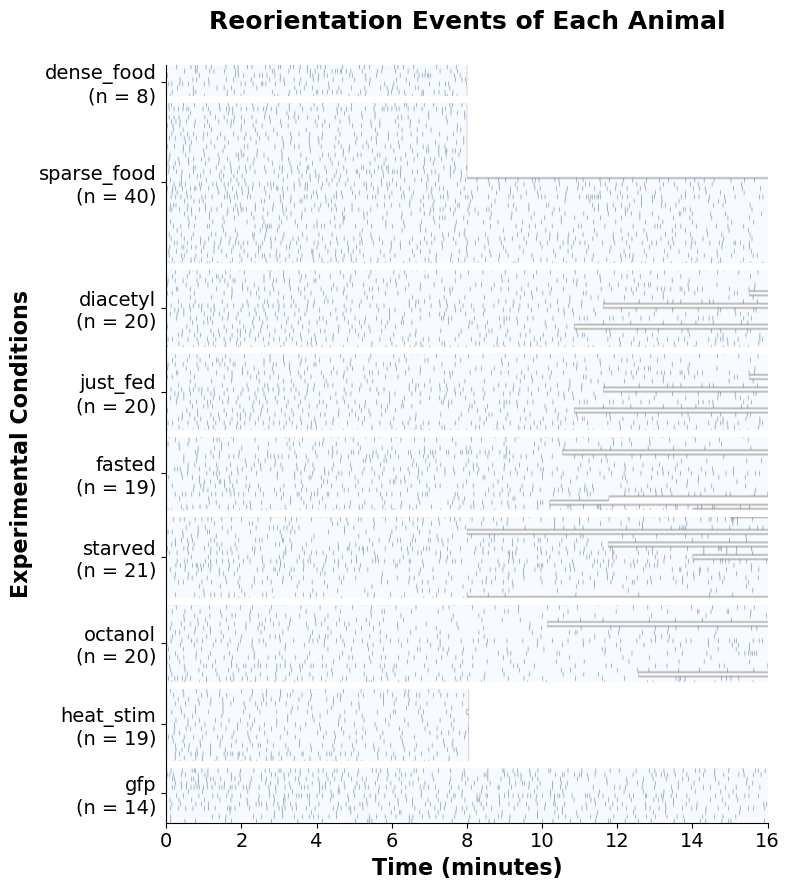

In [11]:
# Reorientation rates

title = 'Reorientation Events of Each Animal'
clabel = 'rad/s'
# Options: 'viridis', 'plasma', 'inferno', 'magma', 'coolwarm', 'RdYlBu', 'RdBu', etc.
colormap = 'Blues'  # Change this to your preferred colormap
vmin = 0.0001
vmax = 0.001

# Sorting options - choose one:
sort_method = None  # Options: None, 'mean', 'max', 'peak_time', 'hierarchical'
data_dict = all_reorientations

plot_heatmap_per_animal(data_dict, 
                        group_order=groups,
                        title=title, show_colorbar=False, vmin=vmin, vmax=vmax, 
                        sort_method=sort_method, colormap=colormap, figsize=(8,9))

/tmp/ipykernel_1081011/416431051.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


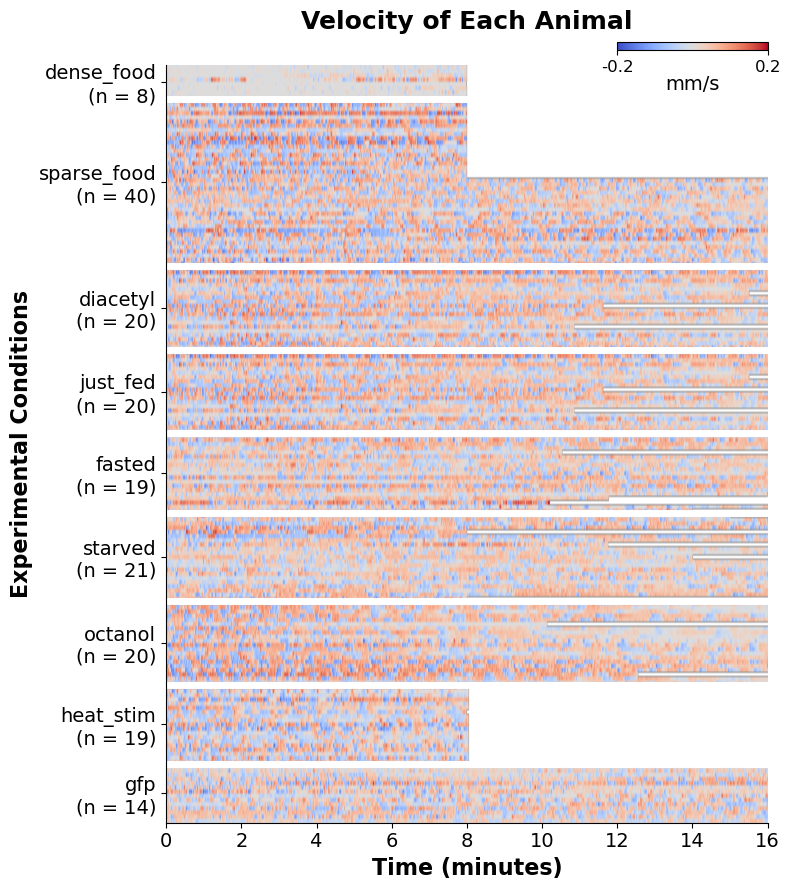

In [12]:
# Velocity

title = 'Velocity of Each Animal'
clabel = 'mm/s'
# Options: 'viridis', 'plasma', 'inferno', 'magma', 'coolwarm', 'RdYlBu', 'RdBu', etc.
colormap = 'coolwarm'  # Change this to your preferred colormap
vmin = -0.2
vmax = 0.2
# Sorting options - choose one:
sort_method = None  # Options: None, 'mean', 'max', 'peak_time', 'hierarchical'
data_dict = all_velocities

plot_heatmap_per_animal(data_dict, 
                        group_order=groups,
                        title=title, clabel=clabel, vmin=vmin, vmax=vmax, 
                        sort_method=sort_method, colormap=colormap, figsize=(8,9))

/tmp/ipykernel_1081011/416431051.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


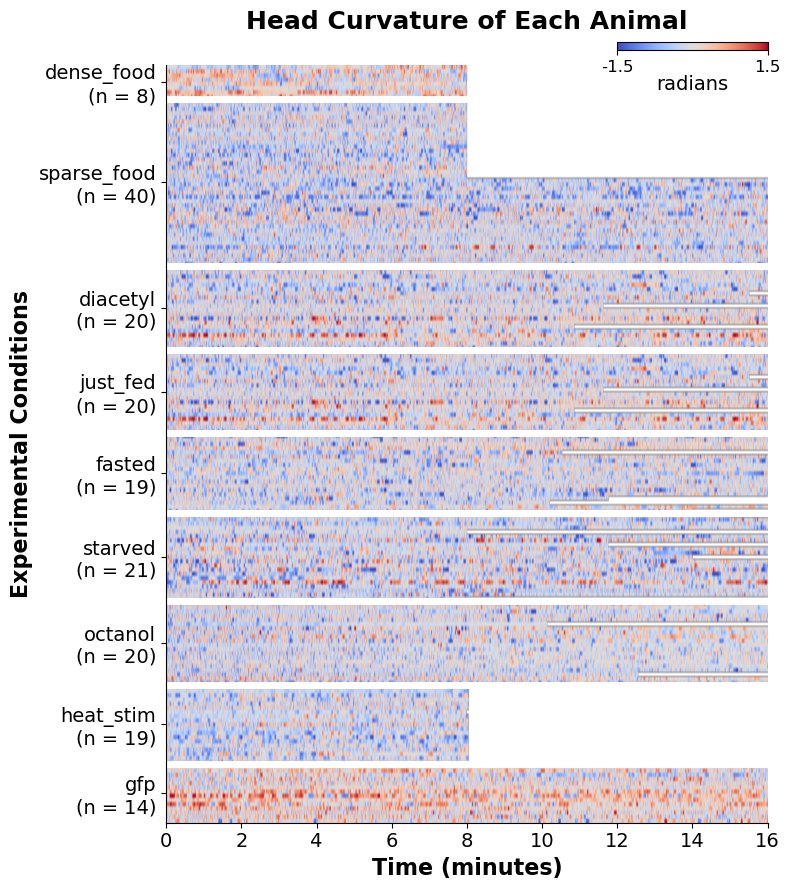

In [14]:
# Head curvature

title = 'Head Curvature of Each Animal'
clabel = 'radians'
# Options: 'viridis', 'plasma', 'inferno', 'magma', 'coolwarm', 'RdYlBu', 'RdBu', etc.
colormap = 'coolwarm'  # Change this to your preferred colormap
vmin = -1.5
vmax = 1.5
# Sorting options - choose one:
sort_method = None  # Options: None, 'mean', 'max', 'peak_time', 'hierarchical'
data_dict = all_head_curvatures

plot_heatmap_per_animal(data_dict, 
                        group_order=groups,
                        title=title, clabel=clabel, vmin=vmin, vmax=vmax, 
                        sort_method=sort_method, colormap=colormap, figsize=(8,9))

/tmp/ipykernel_1081011/416431051.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


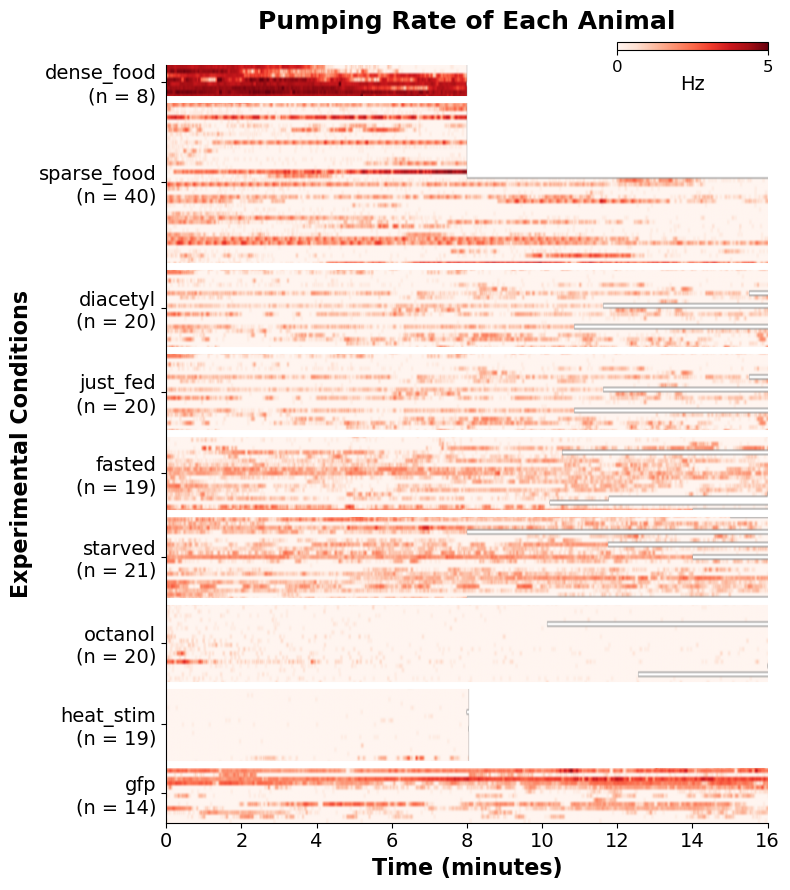

In [15]:
# Pumping

title = 'Pumping Rate of Each Animal'
clabel = 'Hz'
# Options: 'viridis', 'plasma', 'inferno', 'magma', 'coolwarm', 'RdYlBu', 'RdBu', 'gray', 'gray_r', etc.
colormap = 'Reds'  # Change this to your preferred colormap
vmin = 0.0
vmax = 5.0
# Sorting options - choose one:
sort_method = None  # Options: None, 'mean', 'max', 'peak_time', 'hierarchical'
data_dict = all_pumping_rates

plot_heatmap_per_animal(data_dict, group_order=groups, 
                        title=title, clabel=clabel, vmin=vmin, vmax=vmax, 
                        sort_method=sort_method, colormap=colormap, figsize=(8,9))

## Behavior trends aggregated across animals per experimental condition

In [287]:
def kruskal_wallis(data:dict):

    import numpy as np
    from scipy.stats import kruskal
    # Convert dict values into arguments for kruskal
    groups = [np.asarray(vals) for vals in data.values()]

    # Run Kruskal–Wallis test
    stat, pval = kruskal(*groups)

    print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {pval:.3e}")
    return pval

Kruskal-Wallis H-statistic = 91.485, p-value = 8.195e-16


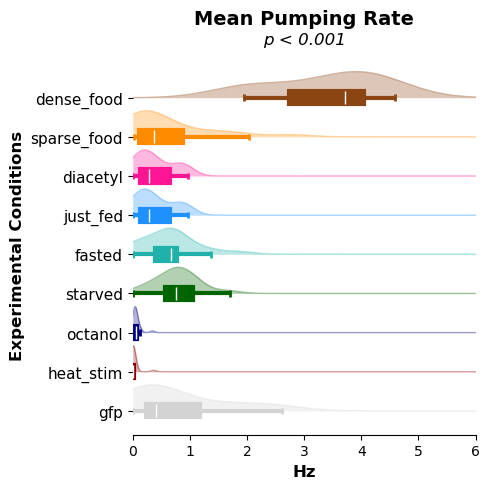

In [330]:
# Get the default color cycle
# default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

pval = kruskal_wallis(all_mean_pumping) * 4

fig, ax = plot_ridge_and_box(all_mean_pumping, 
                     group_order=groups,
                     xlim=(0,6), 
                     title="Mean Pumping Rate\n", 
                     xlabel='Hz', 
                     colors=dict_color,
                     pval=pval
                    )
# plt.savefig('feeding_mean.png')
plt.show()

Kruskal-Wallis H-statistic = 38.464, p-value = 1.439e-05


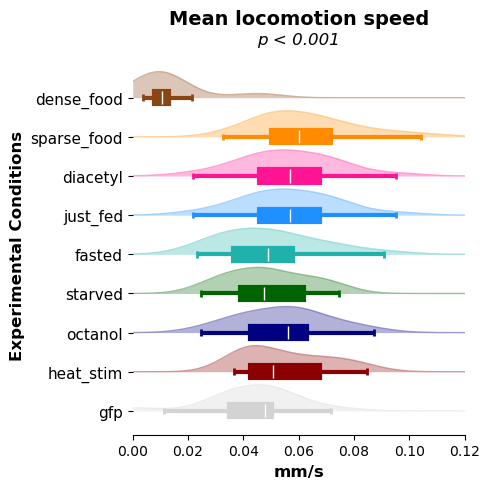

In [331]:
pval = kruskal_wallis(all_mean_speed) * 4

fig, ax = plot_ridge_and_box(all_mean_speed, 
                             group_order=groups,
                             xlim=(0,0.12), 
                             title="Mean locomotion speed\n", 
                             xlabel='mm/s', 
                             colors=dict_color,
                            pval=pval)
# plt.savefig('speed_mean.png')
plt.show()

Kruskal-Wallis H-statistic = 35.820, p-value = 4.267e-05


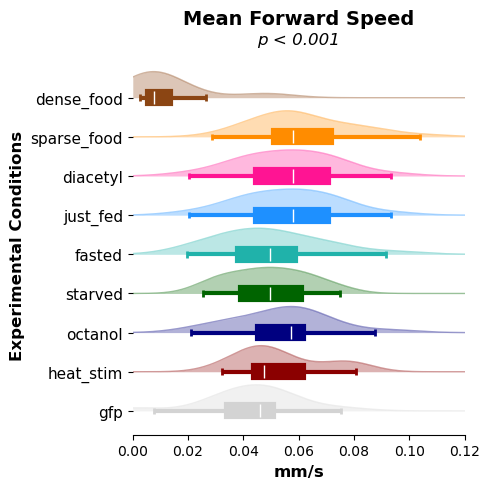

In [332]:
pval = kruskal_wallis(all_mean_fwd_speed) * 4

fig, ax = plot_ridge_and_box(all_mean_fwd_speed, 
                             group_order=groups,
                             xlim=(0,0.12), 
                             title="Mean Forward Speed\n", 
                             xlabel='mm/s', 
                             colors=dict_color,
                            pval=pval)
# plt.savefig('speed_mean.png')
plt.show()

Kruskal-Wallis H-statistic = 39.046, p-value = 1.130e-05


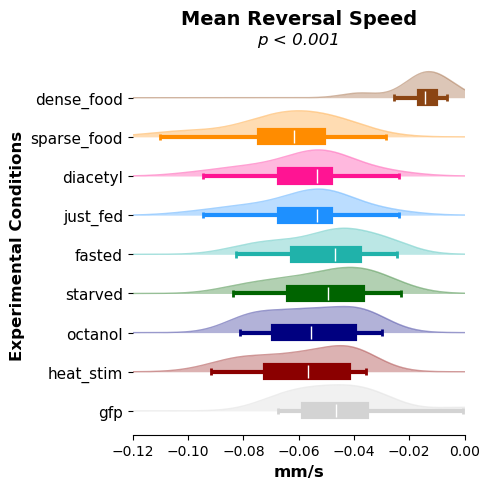

In [333]:
pval = kruskal_wallis(all_mean_rev_speed) * 4

fig, ax = plot_ridge_and_box(all_mean_rev_speed, 
                             group_order=groups,
                             xlim=(-0.12, 0), 
                             title="Mean Reversal Speed\n", 
                             xlabel='mm/s', 
                             colors=dict_color,
                            pval=pval)
# plt.savefig('speed_mean.png')
plt.show()

Kruskal-Wallis H-statistic = 27.289, p-value = 1.253e-03


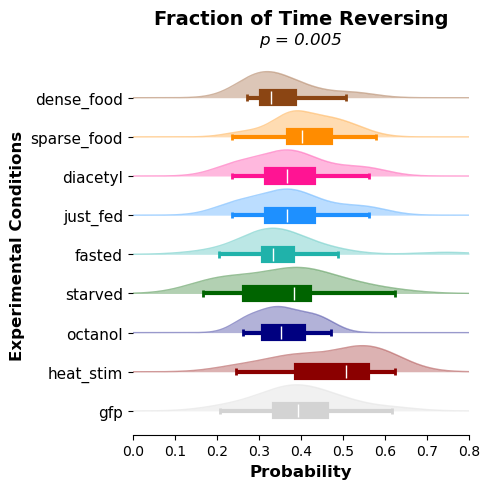

In [334]:
pval = kruskal_wallis(all_frac_rev) * 4

fig, ax = plot_ridge_and_box(all_frac_rev, 
                             group_order=groups,
                             xlim=(0, 0.8), 
                             title="Fraction of Time Reversing\n", 
                             xlabel='Probability', 
                             colors=dict_color,
                            pval=pval)
# plt.savefig('speed_mean.png')
plt.show()